In [1]:
!python -V

Python 3.9.16


In [1]:
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pickle

In [34]:
!mkdir data
!mkdir models

mkdir: cannot create directory ‘data’: File exists


In [4]:
%%capture
!wget -nc https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet -P data
!wget -nc https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet -P data

In [2]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    df = df[(df.duration >=1) & (df.duration <= 60)]
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype('str')
    return df

In [3]:
df_train = read_dataframe('data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('data/green_tripdata_2021-02.parquet')

In [4]:
len(df_train), len(df_val)

(73908, 61921)

/tmp/ipykernel_1774/3707418482.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train["duration"])


<Axes: xlabel='duration', ylabel='Density'>

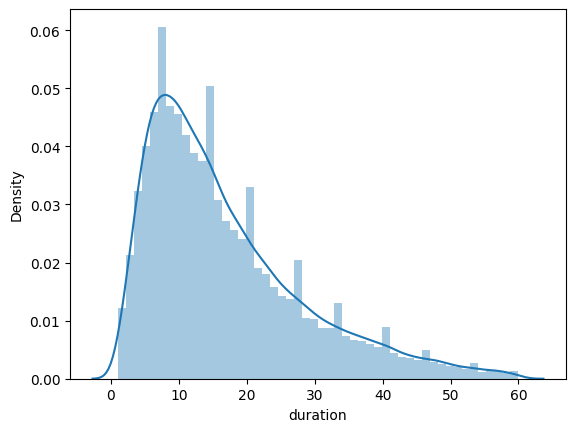

In [7]:
sns.distplot(df_train["duration"])

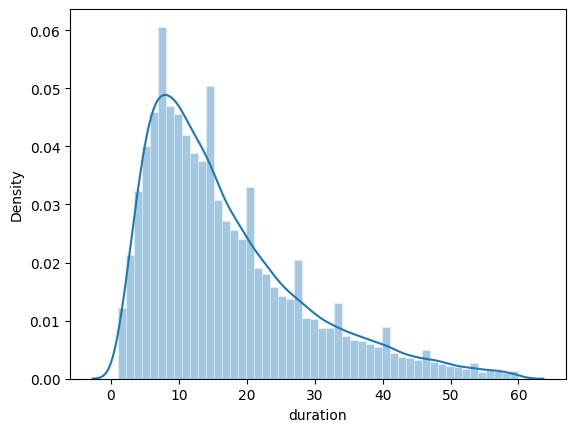

Bad pipe message: %s [b'<\xed\xe8\xf4k\x15B\xbc\x8d\xa2\xe9\xaf\x0bH\x8a\xd1\x94\x8a \xac\xbdA\x83\xc3\xa6\x90\xdc\x08xf`1\xe6\xb1\x85.\xdf\x10\xe3\xba\xf6\x11\x91=wK\xaeE\xcfR\xb2\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x00']
Bad pipe message: %s [b'=\xb4W\xfb\xb7\x1cv\x19\xe7oy\xbb.`&N\x15\xcb \xab\xb1;w_\xd5\x0c\xe2d3\xe4\x1fD\xab\xf6\xaa\xe5H\x9b\xba\xc8\xef:\xc9\xe7\x99\xf0H\xeam\x1d6\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00', b'\x0c\x00\x00\t127.0.0.1']
Bad pipe message: %s [b"\xdf\xd8\xee\x95Y[\x90\x1e\xa6SJc\xe3\x01\xf7\\\x18\xd0\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xa

In [9]:
sns.histplot(
    df_train["duration"] , kde=True,
    stat="density", kde_kws=dict(cut=3), bins=50,
    alpha=.4, edgecolor=(1, 1, 1, 0.4),
);

In [9]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']


In [16]:
categorical = ['PU_DO']
numerical = ['trip_distance'] 

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [17]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [27]:
def plot_prediction_vs_actual_distribution(y_true, y_pred):
    sns.histplot(
        y_pred , kde=True,
        stat="density", kde_kws=dict(cut=3), bins=50,
        label='prediction'
    )
    sns.histplot(
        y_true , kde=True,
        stat="density", kde_kws=dict(cut=3), bins=50,
        label='actual'
    )
    plt.legend()

In [35]:
def predict_and_plot(lr):
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    print('RMSE = ', mean_squared_error(y_true=y_val, y_pred=y_pred, squared=False))
    plot_prediction_vs_actual_distribution(y_true=y_val, y_pred=y_pred)
    return lr

RMSE =  7.758715207562129


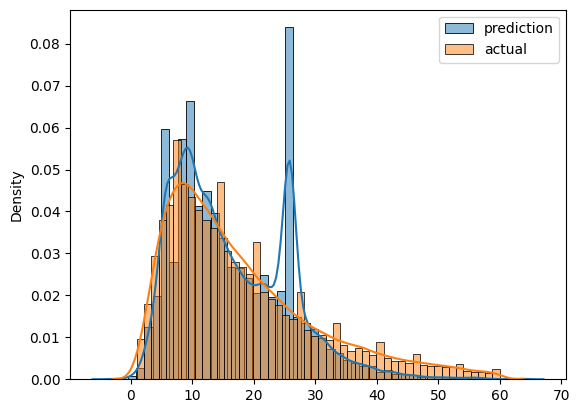

In [36]:
trained_linear_regression = predict_and_plot(LinearRegression())

RMSE =  9.233436225720547


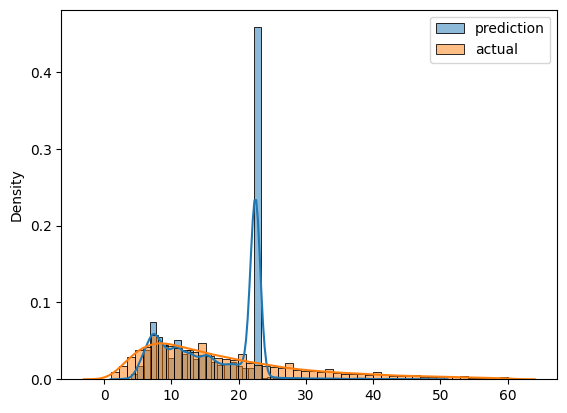

In [37]:
trained_lasso = predict_and_plot(Lasso(alpha=0.001))

RMSE =  7.703735127147203


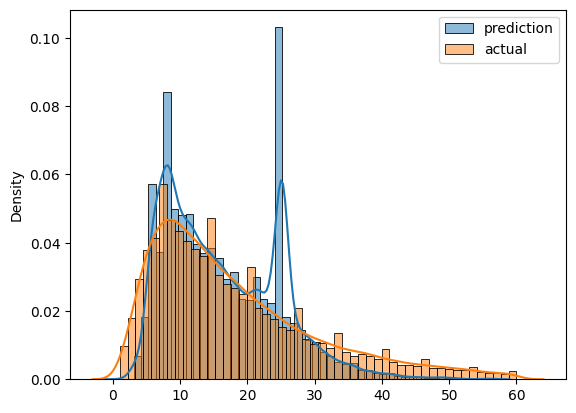

In [38]:
trained_ridge = predict_and_plot(Ridge())

In [39]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, trained_linear_regression), f_out)